<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referenced Materials**

* https://amaarora.github.io/2020/09/13/unet.html
* https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [1]:
# Initialization

%%bash
cd ~
if [ ! -d unet ]; then
  mkdir unet
fi

In [2]:
# Initialize Environment
%cd ~
%cd unet
%env SRC_DIR=sarpol-zahab-tents
%env PYTHON_KEYRING_BACKEND=keyring.backends.null.Keyring

/root
/root/unet
env: SRC_DIR=sarpol-zahab-tents
env: PYTHON_KEYRING_BACKEND=keyring.backends.null.Keyring


In [3]:
# Initialize Directories

%%bash
echo "Working in Directory: $(pwd)"

export D_PATH='data/dataset'
export T_PATH=$D_PATH'/train'
export M_PATH=$D_PATH'/mask'

if [ ! -d $SRC_DIR ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

if [ ! -d $T_PATH ]; then
  mkdir -p $T_PATH
fi

if [ ! -d $M_PATH ]; then
  mkdir -p $M_PATH
fi

Working in Directory: /root/unet


Cloning into 'sarpol-zahab-tents'...


In [4]:
# Download Loss Functions

%%bash
if [ ! -d pneumothorax-segmentation/ ]; then
  git clone https://github.com/sneddy/pneumothorax-segmentation
  cp pneumothorax-segmentation/unet_pipeline/Losses.py .
fi

if [ -d pneumothorax-segmentation/ ]; then
  rm -r pneumothorax-segmentation/
fi

Cloning into 'pneumothorax-segmentation'...


In [5]:
# Installing Packages

# %%bash
# pip3 install -U --user torch torchvision torchaudio

# pip install -U --user glibc
# pip install -U --user torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# pip install -U --user Cython
# pip install -U --user segmentation-models-pytorch
# pip install -U --user albumentations
# pip install -U --user numpy
# pip install -U --user pandas
# pip install -U --user google-colab
# pip install -U --user tornado
# pip install -U --user ipykernel ipython

In [6]:
# Imports
#conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
!pip install segmentation-models-pytorch
!pip install -U albumentations
from tqdm import tqdm


import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import numpy as np
import os
import cv2
import albumentations as albu
from os import environ
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor
from pathlib import Path
from glob import glob
from PIL import Image
#from google.colab.patches import cv2_imshow
from Losses import ComboLoss, dice_metric

!pip install -U --user tensorflow
import tensorflow as tf
print(tf.test.gpu_device_name())

# Read this if not working: https://stackoverflow.com/questions/51002045/how-to-make-jupyter-notebook-to-run-on-gpu
# https://douglasrizzo.com.br/cuda-manjaro/
# https://developer.nvidia.com/cudnn
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe.")

print("device name", torch.cuda.get_device_name(0))



# from https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb

# import os
# import torch
# import numpy as np
# import pandas as pd
# import cv2
# from pathlib import Path
# import matplotlib.pyplot as plt
# import segmentation_models_pytorch as smp
# from torch.utils.data import DataLoader
# import torch.nn as nn
# from collections import defaultdict
# import torchvision
# import albumentations as albu
# from albumentations.pytorch.transforms import ToTensor
# import torch.nn.functional as F
# from sklearn.model_selection import StratifiedKFold
# from torch.utils.data.sampler import Sampler
# import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
# from Losses import ComboLoss, dice_metric


     |████████████████████████████████| 87 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 376 kB 39.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ff4b36cf64408cdd93ff33bd2cad680c0d5e5cf8d918f9a0d43cbd3cc1f1fd15
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=31a53a75ddfc61fc641295c3de4465dae35d373ce63f1761b6eea9eb93dbcb13
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 98 kB 3.8 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    

In [7]:
# Configuration

IMG_FORMAT       = 'png'
IMG_TYPE         = 'RGB'
IMG_SIZE         = 512

SRC_DIR          = environ.get("SRC_DIR")
DATA_DIR         = Path(f'data/dataset/')
TRAIN_IMG_DIR    = DATA_DIR/'train'
TRAIN_LBL_DIR    = DATA_DIR/'mask'



#RLE_DF           = pd.read_csv('../data/train-rle.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
#KFOLD_PATH       = '../data/RLE_kfold.csv'
TRAIN_BATCH_SIZE = 14
VALID_BATCH_SIZE = 14
USE_SAMPLER      = False
POSTIVE_PERC     = 0.8
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None 
DEVICE           = 'cuda'
#PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
PRETRAINED       = False
LEARNING_RATE    = 2e-5
EPOCHS           = 5
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = True
EVALUATE         = False
FOLD_ID          = 4
SUBMIT_TO_KAGGLE = False

In [8]:
# Preparing Data

def load(path):
  return np.array([np.asarray(Image.open(path).convert(IMG_TYPE).resize((IMG_SIZE, IMG_SIZE))) for path in sorted(glob(path))])

src_imgs = load("{}/data/images/*".format(SRC_DIR))
src_lbls = load("{}/data/labels/*".format(SRC_DIR))

if src_imgs.shape[0] == src_lbls.shape[0]:
  n = src_lbls.shape[0]

  for i in range(n):
    Image.fromarray(src_imgs[i]).save("{}/{}.{}".format(TRAIN_IMG_DIR, i, IMG_FORMAT))
    Image.fromarray(src_lbls[i]).save("{}/{}.{}".format(TRAIN_LBL_DIR, i, IMG_FORMAT))



In [9]:
# Cleanup

%%bash
if [ -d $SRC_DIR ]; then
  rm -r $SRC_DIR
fi

In [10]:
# Block

class Block(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, 3) # 2D convolution that doubles number of channels from in_ch to out_ch, kernel size 3
    self.relu = nn.ReLU() # ReLU activation?
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3) # Same as conv1 but goes from out_ch to out_ch

  def forward(self, x):
    return self.relu(self.conv2(self.relu(self.conv1(x))))


# Given an input image with shape 1x572x572 the output shape will be 64x568x568 (because of our convolutions)

# Testing implementation
enc_block = Block(1, 64)
x = torch.randn(1, 1, 572, 572)
enc_block(x).shape

torch.Size([1, 64, 568, 568])

In [11]:
# Encoder - Acts like a standard Convolutional Neural Network
class Encoder(nn.Module):
  def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
    super().__init__()
    self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    ftrs = []
    for block in self.enc_blocks:
      x = block(x)
      ftrs.append(x)
      x = self.pool(x)
    return ftrs



# Testing to make sure it works
encoder = Encoder()
x = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [12]:
# Decoder

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


# testing it
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

In [13]:
# UNet

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

# Testing it
unet = UNet()
x    = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])

In [14]:
# Image Visualization

# From: https://albumentations.ai/docs/examples/example_kaggle_salt/
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [15]:
# Image Augmentation

# Note that UNet type architectures require input image sizes to be dividible by 2^n where n is the number of maxpooling layers
# as such sometimes we may need to pad the images to conform to this requirement

# TODO: might want to change how we do the probabilities
transform = albu.Compose([
  albu.HorizontalFlip(),
  albu.Rotate(10),
  ToTensor(), # If we use this we can't use visualize on the augmented image
])

# TODO: look into using JSON instead of an array of dictionaries
dataset = []
# Dataset Structure:
# [
#   0:{
#     original:  {image, mask},
#     augmented: {image, mask},
#     path:      {image, mask}
#   },
#   1:{}, 2:{}, n:{}
# ]

for path in [tuple(pair) for pair in np.stack((sorted(glob("{}/train/*".format(DATA_DIR))), sorted(glob("{}/mask/*".format(DATA_DIR)))), axis=1)]:
  image = cv2.imread(path[0])
  mask = cv2.imread(path[1])
  dataset.append({"original":{"image":image, "mask":mask}, "augmented":transform(image=image, mask=mask), "path":{"image":path[0],"mask":path[1]}})

# for image in dataset[:1]:
#   print(image["path"])
#   visualize(image["augmented"]["image"], image["augmented"]["mask"], original_image=image["original"]["image"], original_mask=image["original"]["mask"])

In [16]:
# dataloaders
train_dataloader = DataLoader(dataset[:200], TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=4, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(dataset[200:], VALID_BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 512, 512]) torch.Size([512, 512, 3])


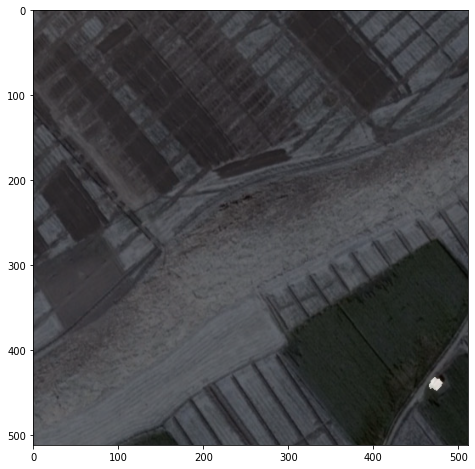

In [17]:
# Visualize

# sanity check
image, mask = dataset[0]["augmented"]["image"], dataset[0]["augmented"]["mask"]
print(image.shape, mask.shape)

# Only seems to work with augmented images?
# From: https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb
def overlay(images):
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask, alpha=0.5)
    plt.show()

overlay(dataset[0]["augmented"])

In [18]:






# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()



# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [19]:
# from https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [20]:
# From: https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb

class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [21]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['image'])
        loss = loss_fn(out, data['mask'])
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [22]:
# pixel-wise accuracy
def acc_metric(input, target):
    inp = torch.where(input>0.5, torch.tensor(1, device='cuda'), torch.tensor(0, device='cuda'))
    acc = (inp.squeeze(1) == target).float().mean()
    return acc

In [23]:

# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [24]:
def evaluate(valid_loader, model, device='cuda', metric=dice_metric):
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['image'])
            out   = torch.sigmoid(out)
            dice  = metric(out, data['mask']).cpu()
            losses.update(dice.mean().item(), valid_loader.batch_size)
            tk0.set_postfix(dice_score=losses.avg)
    return losses.avg

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

In [26]:
criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION 
es = EarlyStopping(patience=10, mode='max')

In [27]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        dice = evaluate(val_dataloader, model, metric=metric)
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")
        es(dice, model, model_path=f"../data/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
        best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
if EVALUATE:
    valid_score = evaluate(val_dataloader, model, metric=metric)
    print(f"Valid dice score: {valid_score}")

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/15 [00:00<?, ?it/s]


AttributeError: ignored